# Human Emotion Detection using Convolutional Neural Network
 


This repository refers to my postgraduate project.Transfer learning was applied to the `MobileNet` model to design the CNN model used in this project. For facial emotion recognition in this project, the model would have seven output classes instead of the 1000 classes in the `MobileNet` model. 

The dataset used is [FER 2013 dataset](https://www.kaggle.com/msambare/fer2013). The validation set was created from about 10% of the test set.The dataset
I used consists of 48 x 48-pixel grayscale images of faces, it consists of a training set and a test set that contains 28,709 and 3589 examples respectively divided into seven classes (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

The trained model can be downloaded from my google drive:  [The_trained_model](https://drive.google.com/file/d/1VznCm1BMlxiBdErZWYZ_d5qsP8Ia17Nj/view?usp=sharing)

### Rquirements to run the script
The code is wrritten in python, a suitable IDE that is compatible with python will be required to run the code.


In [ ]:
# Install the necessary libraries using "pip" from command line
pip install tensorflow
pip install numpy
pip install sklearn
pip install matplotlib

In [1]:
# Import all the necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from itertools import cycle
import itertools
import os
import shutil
import random
import glob
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize


In [2]:
# create validation_set from train_set
os.chdir('FER-2013')
if os.path.isdir('valid/angry') is False:
    os.makedirs('valid/angry')
    os.makedirs('valid/disgust')
    os.makedirs('valid/fear')
    os.makedirs('valid/happy')
    os.makedirs('valid/neutral')
    os.makedirs('valid/sad')
    os.makedirs('valid/surprise')
    
    for i in random.sample(glob.glob('train/angry/Training*'), 400):
        shutil.move(i, 'valid/angry')
    for i in random.sample(glob.glob('train/disgust/Training*'), 60):
        shutil.move(i, 'valid/disgust') 
    for i in random.sample(glob.glob('train/fear/Training*'), 400):
        shutil.move(i, 'valid/fear') 
    for i in random.sample(glob.glob('train/happy/Training*'), 400):
        shutil.move(i, 'valid/happy')      
    for i in random.sample(glob.glob('train/neutral/Training*'), 400):
        shutil.move(i, 'valid/neutral') 
    for i in random.sample(glob.glob('train/sad/Training*'), 400):
        shutil.move(i, 'valid/sad') 
    for i in random.sample(glob.glob('train/surprise/Training*'), 400):
        shutil.move(i, 'valid/surprise') 
os.chdir('../')


In [3]:
# Create and assign variables to the path (train, valid, test) data directories. 
train_path = 'FER-2013/train'
valid_path = 'FER-2013/valid'
test_path = 'FER-2013/test'

### Preprocess images

`ImageDataGenerator.flow_from_directory()` creates a `DirectoryIterator` that generates batches of preprocessed image data from the respective directories.

`Preprocessing_function=tf.keras.applications.mobilenet.preprocess_input` was used to scale input pixels of the images between the scale of -1 and 1 per image.

Using TensorFlow `flow_from_directory` function, the images are resized to 224 x 224 pixel to fit the input of the fine tunned model and also mapped to the seven output classes.

In [4]:
# Use Keras ImageDataGenerator class to create batches of data from the train, valid, test directories.
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224),classes=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], batch_size=30)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224),classes=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], batch_size=30)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224),classes=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], batch_size=30, shuffle=False)

Found 26249 images belonging to 7 classes.
Found 2460 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Fine tune `MobileNet` model 

In [5]:
# Import MobileNet model from Keras.
mobileNet =tf.keras.applications.MobileNet()

# Convert MobileNet from a functional model to a sequential model.
# Create a new squential model and iterate over each layers in the MobileNet model except the last 19 layers.
model = Sequential()
for layer in mobileNet.layers[:-19]:
    model.add(layer)

# Iterate over each layers in the new sequtial model and set them to be non-trainable.
for layer in model.layers:
    layer.trainable = False

# Add a flatten layer and an output layer consisting of 7 nodes classes (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral) 
model.add(Flatten())
model.add(Dense(units=7, activation='softmax'))

# This displays the summary of the fined tuned model
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0         
_________________________________________________________________
conv_pw_1 (Conv2D)           (None, 112, 112, 64)      2

### Compile and train fine tunned model

In [ ]:
# Compile and train the model
model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
model.fit(x=train_batches,
    validation_data=valid_batches,
    epochs=30,
    verbose=2,
    steps_per_epoch=len(train_batches),
    validation_steps=len(valid_batches),      
)

# Save the model
model.save('/content/FER-dataset/emotion_detection_model.h5')


### Load model and test result

In [6]:
# Load the model
model = load_model('emotion_detection_model.h5')

# Evaluate trained model to determine test accuracy.
model.evaluate(test_batches)


240/240 [==============================] - 127s 524ms/step - loss: 16.3634 - accuracy: 0.5897


[16.363372802734375, 0.5897185802459717]

### Plot Confusion matrix
`plot_confusion_matrix` function was gotten from [scikit-learn's website](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py).

In [7]:
# Prediction of the model
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

# Create confusion matrix and assigned it to "cm"
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

# Use plot_confusion_matrix function from scikit-learn's website.
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],decimals=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.55 0.01 0.11 0.06 0.13 0.13 0.02]
 [0.24 0.46 0.07 0.04 0.06 0.11 0.02]
 [0.16 0.   0.41 0.04 0.15 0.17 0.07]
 [0.05 0.   0.02 0.77 0.09 0.05 0.01]
 [0.13 0.   0.05 0.07 0.61 0.12 0.01]
 [0.16 0.   0.1  0.08 0.21 0.43 0.02]
 [0.06 0.   0.09 0.06 0.06 0.03 0.69]]


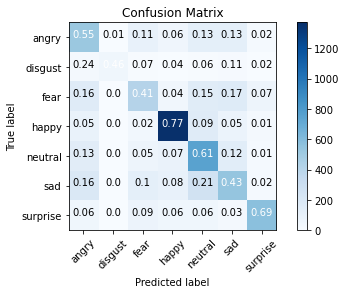

In [8]:
# Define the labels for the confusion matrix
cm_plot_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Pass in the confusion matrix "cm", the labels "cm_plot_labels" and the title for the confusion matrix to "plot_confusion_matrix()" to plot the confusion matrix.
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')


### Plot (AUC) - (ROC) curve

In [10]:
# Assign variables n_classes and test_labels to number of classes (7) and to test_batches.classes.
n_classes = 7
test_labels = test_batches.classes 

# Binarize the labels
test_labels = label_binarize(test_labels, classes=[0, 1, 2,3,4,5,6])
n_classes = test_labels.shape[1]

# Plot linewidth.
lw = 1

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


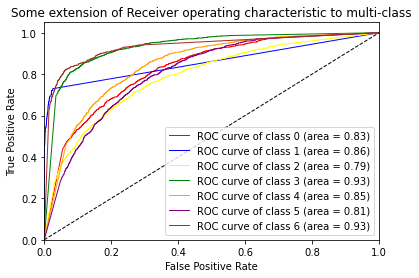

In [11]:

# Plot all ROC curves
plt.figure(1)
colors = cycle(['red', 'blue', 'yellow', 'green', 'orange', 'purple', 'brown'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
    label='ROC curve of class {0} (area = {1:0.2f})'
    ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [12]:
# Displays Mapped label classes
test_batches.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}